# Récupération et tri des stations disponibles

> Récupération des stations des réseaux `FR`, `RD`, et `G` disponibles pendant la période de COVID-19 débutant le **15 Février 2020**.

## Importation des modules

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from seismic_noise import *

from obspy import UTCDateTime, read_inventory
from obspy.clients.fdsn import Client
from obspy.clients.fdsn.client import FDSNNoDataException

## Récupération des stations du territoire métropolitain

In [2]:
client = Client("RESIF")
tStart = "2020-02-15"
tEnd = "2021-07-31"
load_stations = True
st_file = "DATA/st_metadata/stations_fr.xml"
st_availability = "DATA/st_metadata/stations_fr_availability.csv"
network = "FR,G,RD"
channel = "HHZ"
percent_keep = 0.75

#### Récupération des disponibilités via le constructeur de requêtes availability

In [3]:
url = "https://ws.resif.fr/fdsnws/availability/1/query?\
network={}&channel={}&starttime={}&endtime={}&format=text&\
orderby=nslc_time_quality_samplerate&includerestricted=true&nodata=404".format(network, channel, tStart, tEnd)
urllib.request.urlretrieve(url, st_availability)

data_availability = pd.read_csv(st_availability, delim_whitespace=True)
data_availability

,#Network,Station,Location,Channel,Quality,SampleRate,Earliest,Latest
0,FR,ABJF,00,HHZ,M,100.0,2020-02-15T00:00:00.000000Z,2020-02-29T00:00:02.330000Z
1,FR,ABJF,00,HHZ,M,100.0,2020-03-01T00:00:01.840000Z,2020-05-25T01:17:12.430000Z
2,FR,ABJF,00,HHZ,M,100.0,2020-05-25T01:17:16.560000Z,2020-08-15T04:30:03.170000Z
3,FR,ABJF,00,HHZ,M,100.0,2020-08-15T04:37:17.890000Z,2020-08-15T04:37:41.420000Z
4,FR,ABJF,00,HHZ,M,100.0,2020-08-15T04:37:43.290000Z,2021-02-17T10:50:02.700000Z
...,...,...,...,...,...,...,...,...
24875,RD,SAVF,--,HHZ,M,100.0,2021-07-26T13:30:00.000000Z,2021-07-26T13:33:29.990000Z
24876,RD,SAVF,--,HHZ,M,100.0,2021-07-26T13:33:50.000000Z,2021-07-26T13:53:09.990000Z
24877,RD,SAVF,--,HHZ,M,100.0,2021-07-26T13:54:30.000000Z,2021-07-26T13:55:39.990000Z
24878,RD,SAVF,--,HHZ,M,100.0,2021-07-26T14:01:20.000000Z,2021-07-27T07:06:29.990000Z


#### Liste des stations

In [4]:
st_list = []
for i in range(len(data_availability["#Network"])):
    loc_name = data_availability["Location"][i]
    #if loc_name == "--": loc_name=""
    st_name = "{}.{}.{}.{}".format(data_availability["#Network"][i],data_availability["Station"][i],loc_name,data_availability["Channel"][i])
    st_list.append(st_name)

code = data_availability["Station"]

st_list_unique = []
for x in st_list:
    if x not in st_list_unique:
        st_list_unique.append(x)
st_list = st_list_unique

#### On garde les stations avec suffisamment de jours de données

In [5]:
diff_list = []
code = []
ndays_period = int( (UTCDateTime(tEnd)-UTCDateTime(tStart))/(3600*24) )

for code_name in st_list: 
    (net_name, st_name, loc_name, cha_name) = code_name.split('.')
    t1 = data_availability["Earliest"].loc[ data_availability["#Network" ] == net_name].loc[ data_availability["Station" ] == st_name].loc[ data_availability["Location"] == loc_name ].loc[ data_availability["Channel" ] == cha_name].tolist()
    t2 = data_availability["Latest"].loc[ data_availability["#Network" ] == net_name].loc[ data_availability["Station" ] == st_name].loc[ data_availability["Location"] == loc_name ].loc[ data_availability["Channel" ] == cha_name].tolist()
    t1 = np.asarray([UTCDateTime(t1[i]) for i in range(len(t1))])
    t2 = np.asarray([UTCDateTime(t2[i]) for i in range(len(t2))])
    diff = int( sum((t2-t1) / (3600*24)) )
    if diff >= percent_keep*ndays_period:
        diff_list.append(diff)
        code.append(st_name)

code_unique = []
for x in code:
    if x not in code_unique:
        code_unique.append(x)
code = ",".join(code_unique)

#### Récupération des stations

In [6]:
tStart = UTCDateTime(tStart)
tEnd = UTCDateTime(tEnd)

if load_stations:
    inventory = client.get_stations(network=network,
                                    channel=channel, # Eventuellement BHZ pour l'antarctique
                                    station=code,
                                    level="channel",
                                    starttime=tStart, endtime=tEnd,
                                    minlatitude=41, maxlatitude=52, minlongitude=-5, maxlongitude=10)
    # inventory = inventory.remove(network="FR", station="STR", location="10", channel="HHZ")
    # inventory = inventory.remove(network="FR", station="NIMR", location="10", channel="HHZ")
    inventory.write(st_file, format="STATIONXML") 

In [7]:
inventory = read_inventory(st_file)
inventory

Inventory created at 2021-08-18T22:56:22.000000Z
	Created by: RESIF WEB SERVICE: fdsnws-station | version: 1.1.1 
		    http://ws.resif.fr/fdsnws/station/1/query?starttime=2020-02-15T00%3...
	Sending institution: RESIF-SI (RESIF-DC)
	Contains:
		Networks (3):
			FR, G, RD
		Stations (137):
			FR.ABJF (Abjat-sur-Bandiat)
			FR.AGO (Saint-Agoulin)
			FR.AJAC (Ajaccio)
			FR.ARBF (technopole de l'Arbois)
			FR.ARTF (Artigues)
			FR.ATE (Arette)
			FR.BALS (Balsièges)
			FR.BANN (fort de Banne)
			FR.BARI (Barisis-aux-Bois)
			FR.BEGF (Béganne)
			FR.BLAF (Les Blancs)
			FR.BOUC (Bouclans)
			FR.BRGF (Bourganeuf)
			FR.BSTF (La Bastide-des-Jourdans)
			FR.CALF (plateau de Calern)
			FR.CAMF (Camaret-sur-Mer)
			FR.CARF (Carcanières)
			FR.CFF (63014, Aubière)
			FR.CHIF (Chizé)
			FR.CHLF (Chalmoux)
			FR.CHMF (Charmoille)
			FR.CIEL (Vacanciel)
			FR.CLAF (montagne de la Clape)
			FR.CLEV (Clévilliers)
			FR.CLF (Chambon-la-Forêt)
			FR.CLMF (Criteuil-la-Magdeleine)
			FR.COLF (Collangett

ValueError: 'c' argument has 144 elements, which is inconsistent with 'x' and 'y' with size 137.

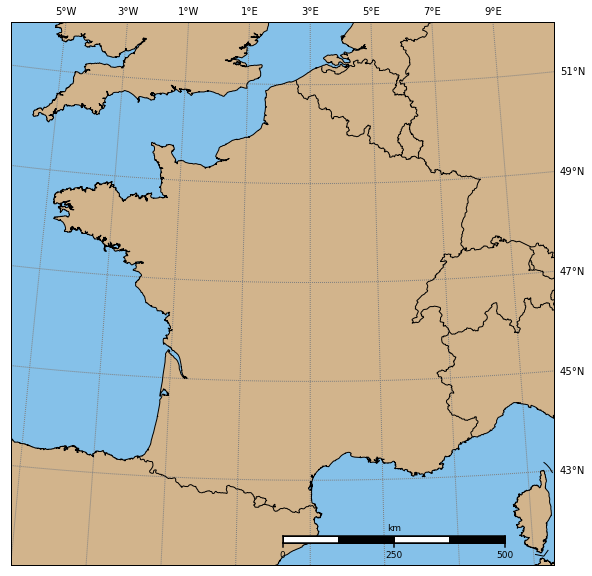

In [8]:
# Récupération des informations
lat = [ inventory.networks[j].stations[i].latitude for j in range(len(inventory.networks)) for i in range(len(inventory.networks[j].stations)) ]
lon = [ inventory.networks[j].stations[i].longitude for j in range(len(inventory.networks)) for i in range(len(inventory.networks[j].stations)) ]

code = inventory.get_contents()["channels"]
code_unique = []
for x in code:
    if x not in code_unique:
        code_unique.append(x)
code = code_unique
network = [ code_name.split(".")[0] for code_name in code ]
colors = list();
for code_name in code:
    network = code_name.split(".")[0]
    if network=="FR": colors.append("#991818")
    if network=="G" : colors.append("#537FB4")
    if network=="RD": colors.append("#499E42")
    

# Mise en graphique
plt.figure(figsize=(10,10))
latmin = 41
latmax = 52
lonmin = -5
lonmax = 11
resol = "h"
bar_width = 500
bar_pos = 4

# Définition du type de carte
m = Basemap(llcrnrlon=lonmin,llcrnrlat=latmin,urcrnrlon=lonmax,urcrnrlat=latmax,\
            width=12000000,height=9000000,\
            rsphere=(6378137.00,6356752.3142), epsg=5520,\
            resolution=resol,area_thresh=1000.,projection='cyl',\
            lat_1=latmin,lat_2=lonmin,lat_0=latmax,lon_0=lonmax)

m.drawcountries(linewidth=1, zorder=10)
m.drawcoastlines(linewidth=1, zorder=10)
parallels = np.arange(latmin, latmax,2.)
meridians = np.arange(lonmin, lonmax,2.)
m.drawparallels(parallels,labels=[False,True,True,False], color="gray", zorder=1, linewidth=1)
m.drawmeridians(meridians,labels=[False,True,True,False], color="gray", zorder=1, linewidth=1)
m.drawmapboundary(fill_color='#85C1E9')
m.fillcontinents(color='tan',lake_color='lightblue')
    
# Positionnement dans les coins
if   bar_pos==1: a, b, c = -0.35, +1, 95
elif bar_pos==2: a, b, c =   0.5, -1, 95
elif bar_pos==3: a, b, c = -0.35, +1, 8
else           : a, b, c =  0.36, -1, 7

lat_pos = np.linspace(latmin, latmax, 100)[c]
lon_pos = a*abs(lonmax-lonmin) + b*bar_width/111.0/2.0 + 4.2e-2*lat_pos
m.drawmapscale(lon_pos, lat_pos, lon_pos, lat_pos, bar_width, barstyle='fancy', zorder=100, yoffset=1500*abs(latmax-latmin))

lon, lat  = m(lon, lat)
m.scatter(lon, lat, s=50, marker="o", zorder=20, edgecolors='black', color=colors, alpha=0.8)

# Affichage de la légende
l1 = plt.scatter([],[], s=50, edgecolors='black', alpha=0.8, color="#991818")
l2 = plt.scatter([],[], s=50, edgecolors='black', alpha=0.8, color="#537FB4")
l3 = plt.scatter([],[], s=50, edgecolors='black', alpha=0.8, color="#499E42")

labels = ["FR ({})".format(len(inventory.networks[0])),
          "G ({})".format(len(inventory.networks[1])),
          "RD ({})".format(len(inventory.networks[2]))]

leg = plt.legend([l1, l2, l3], labels, ncol=1, frameon=True, fontsize=12,
                 handlelength=1, loc=3, borderpad = 1, handletextpad=1,scatterpoints = 1)

## Récupération des stations en Antarctique

In [ ]:
client = Client("RESIF")
load_stations = False
st_file = "DATA/st_metadata/stations_antartctic.xml"

In [ ]:
if load_stations:
    inventory = client.get_stations(network="G",
                                    station="CCD,DRV",
                                    location="00",
                                    channel="BHZ,EHZ,HHZ", # Eventuellement BHZ pour l'antarctique
                                    level="channel")
    inventory.write(st_file, format="STATIONXML")  

In [ ]:
inventory = read_inventory(st_file)
inventory

In [ ]:
# Récupération des informations
lat = [ inventory.networks[j].stations[i].latitude for j in range(len(inventory.networks)) for i in range(len(inventory.networks[j].stations)) ]
lon = [ inventory.networks[j].stations[i].longitude for j in range(len(inventory.networks)) for i in range(len(inventory.networks[j].stations)) ]

code = inventory.get_contents()["channels"]
code_unique = []
for x in code:
    # check if exists in unique_list or not
    if x not in code_unique:
        code_unique.append(x)
code = code_unique

# Mise en graphique
plt.figure(figsize=(10,10))
resol = "h"

# Définition du type de carte
m = Basemap(projection='spstere', boundinglat=-60, lon_0=0, resolution=resol)

m.fillcontinents(color='gray',lake_color='gray')
m.drawcountries(linewidth=1, zorder=10)
m.drawcoastlines(linewidth=1, zorder=10)
m.drawparallels(np.arange(-80.,81.,20.),labels=[False,False,False,False], color="gray", zorder=1, linewidth=1)
m.drawmeridians(np.arange(-180.,181.,20.),labels=[True,True,True,True], color="gray", zorder=1, linewidth=1)
m.drawmapboundary(fill_color='#85C1E9')
m.fillcontinents(color='tan',lake_color='lightblue')    

lon, lat  = m(lon, lat)
m.scatter(lon, lat, s=50, marker="o", zorder=20, edgecolors='black', color="#991818")

# Affichage de la légende
l1 = plt.scatter([],[], s=50, edgecolors='black', alpha=0.8, color="#991818")

labels = ["G ({})".format(len(inventory.networks[0]))]

leg = plt.legend([l1], labels, ncol=1, frameon=True, fontsize=12,
                 handlelength=1, loc=3, borderpad = 1, handletextpad=1,scatterpoints = 1)